In [61]:
from IPython.display import HTML

HTML('''<script>
hide_code=true; 
function code_toggle() {
   if (hide_code){
       $('div.input').hide();
   } else {
       $('div.input').show();
   }
   hide_code = !hide_code
} 
$( document ).ready(code_toggle);
</script>
NOTE: the code in this notebook is hidden for better readability.  
To toggle on/off, click <a href="javascript:code_toggle()">here</a>.''')

# <center>Proposal – Data Science Practicum I </center>
## <center>Dstl Satellite Imagery Feature Detection Problem: </center>


My work and educational background is in environmental sciences and I have experience in GIS and remote sensing.  Given my background, I want to do a visualization problem.  On kaggle, I found the Dstl Satellite Imagery Feature Detection Problem that supplies several 1km x 1km Satellite Images and the objective is to detect and classify the following objects found on the satellite images:

* Buildings – large buildings, residential, non-residential, fuel storage facilities, fortified buildings
* Misc. Man-made structures
* Roads
* Tracks – poor/dirt/cart tracks, footpaths/trails
* Trees – woodlands, hedgerows, groups of trees, standalone trees
* Crops – contour plowing/croplands, grain (wheat) crops, row (potatoes, turnips) crops
* Waterways
* Standing water
* Large Vehicle – large vehicles (e.g. lorry, trucks, buses), logistics vehicles
* Small Vehicle – cars, vans, motorbikes

A discription of the problem can be found here:  www.kaggle.com/c/dstl-satellite-imagery-feature-detection

I want to use the classification problem to compare different classification models and the model performances.  I Therefore I am modifying the problem 


I will slightly modified the problem
Using Python, I will first use different types of classification methods such as SVM and k-mean to detect the objects.  

I slightly modify the problem and will compare the classifications and determine which method worked best. The classifications will be performed on each image-pixel this means that features such as object shapes, size and texture will not be accounted for when analyzing the satellite images.  To account for such features, it might be better to use deep learning.  Therefore if time permits a classification model will be performed using deep learning to determine if better results will be obtained using this method.

### DATA:

The Dstl Satellite Imagery Feature Detection Problem supplies you with 1km x 1km satellite images of 360 different locations taken using the WorldView-3 Satellite.  WorldView-3 takes multispectral and Panchromatic images of a region .  Multispectral images capture image data at specific frequencies across the electromagnetic spectrum.  Panchromatic images, on the other hand, are images that are sensitive to a wide range of wavelengths of light.

<img src=http://content.satimagingcorp.com.s3.amazonaws.com/static/galleryimages/worldview-3-spectral-bands.jpg>

Two types of imagery spectral content are provided, 3-band and 16-band images.  The 3-band consist of the RGB color bands with a resolution of ~0.3m.  The 16 band images consist of 8-Multispectral band images with a resolution of 1.24m, 8-SWIR (Short Wave Infrared) band images with a delivered resolution of ~7.5m and Panchromatic images with a resolution of 0.31m.  Details about the images are given in the table below:


|**8 Multispectral band – resolution 1.24m**||
|---------------------------------------|
|Coastal:|                  400 - 450 nm|
|Blue: |450 - 510 nm|
|Green: |510 - 580 nm|
|Yellow: |585 - 625 nm|
|Red: |630 - 690 nm|
|Red Edge: |705 - 745 nm|
|Near-IR1: |770 - 895 nm|
|Near-IR2: |860 - 1040 nm|
|**8 SWIR - delivered resolution ~7.5m**||
|SWIR-1: |1195 - 1225 nm|
|SWIR-2: |1550 -1590 nm|
|SWIR-3: |1640 -1680 nm|
|SWIR-4: |1710 -1750 nm|
|SWIR-5: |2145 - 2185 nm|
|SWIR-6: |2185 - 2225 nm|
|SWIR-7: |2235 - 2285 nm|
|SWIR-8: |2295 - 2365 nm|
|**Panchromatic – resolution 0.31m**||
|Panchromatic: |450 - 800 nm|

In addition to satellite images, training data for 25 of the image locations is provided.  The training data are georeferenced polygon files of classified objects found in the 25 different images.

### DATA SOURCE:
The data for this problem can be downloaded at:
www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data

|File Name|Available Formats|
|----------------|
|sample_submission.csv|.zip (14.89 kb)|
|grid_sizes.csv|.zip (2.17 kb)|
|sixteen_band|.zip (7.30 gb)|
|three_band|.zip (12.87 gb)|
|train_geojson_v3|.zip (14.22 mb)|
|train_wkt_v4.csv|.zip (11.08 mb)|

### ANALYZES

The supplied WorldView-3 satellite images contains multispectral bands.  These bands contain data that might not be visible to the human eye.  For example, looking at the RGB image below-left we see a football field with grass.  However when examaning the image using near-Infrared we can determine that the field is actually made of artificial turf.

<img src=http://adurkin.weebly.com/uploads/1/3/8/9/13890414/9788139_orig.png>

As all the bands give different information, we want to use the information off all these bands to try and classify objects found in the Satellite images.  However, the 3-band data that was supplied is pan-sharpened data created from the Panchromatic Images and the RGB Layers Bands.  I will therefore not use this data for the analysis only use the 16-band data that was given.
The three different types of images all have a different resolution.  For data to be analyzed using traditional classification methods, The images would have to be resampled to match resolutions.  In order to focus on the analysis part of the project, I will first solely look at the 8-Multispectral image.  When this Analysis is complete, I will go back, resample the images to matching resolutions and perform the analysis with 17 features (8-Multispectral images, 8-SWIR images, Panchromatic Images)







In [6]:
%matplotlib inline
import os
import numpy as np
import csv
import math
import ogr
import pickle
from osgeo import gdal, osr, gdalconst
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import itertools
import matplotlib.pyplot as plt

The first step of the analyzes using python is to convert the 25 satellite images that have test data to a data matrix that contains row, column and band data for each pixel.  I will first import the images (GeoTiffs format) using Gdal and then convert the images to a Numpy array.  I will then reshape the Numpy arrays to a data matrix and concatanate all the band data so that everything is contained in one matrix
The next step will be to import the polygon files (Geojson format) and to rasterize the files.  Both processes will be done using Gdal.  After the files have been rasterized, they will be converted to Numpy arrays, reshaped to a data matrix. 

* only analyzing pixels therefore polygon files needs to get rasterize data needs to be re-formatted into a data matrix where the rows in the matrix contains all data for an individual pixel

In [3]:


#----------------FUNCTION: Import satellite images----------------------------------------------------------------------#


def importsatimage(imagename):
    
    imagenameM = imagename + "_M.tif"    
    #print imagenameM
    satM = gdal.OpenShared(os.path.join('sixteen_band/',imagenameM),gdalconst.GA_Update)
    
        # Open the data source and read in the extent
    
    if os.path.isfile('sixteen_band/'+imagenameM):
        satM = gdal.OpenShared(os.path.join('sixteen_band/',imagenameM),gdalconst.GA_Update)
    else:
        raise IOError('Could not find file ' + imagenameM)
    if satM is None:
        raise IOError('Could open file ' + str(satM))
        
    return satM

#---------------FUNCTION: Convert Geotiff files to numpy arrays, resize the arrays same size---------------------------#

def geotiff2numpy(sat, dir):

    L1 = np.array(sat.GetRasterBand(1).ReadAsArray(),dtype=np.int16)
    L2 = np.array(sat.GetRasterBand(2).ReadAsArray(),dtype=np.int16)
    L3 = np.array(sat.GetRasterBand(3).ReadAsArray(),dtype=np.int16)
    L4 = np.array(sat.GetRasterBand(4).ReadAsArray(),dtype=np.int16)
    L5 = np.array(sat.GetRasterBand(5).ReadAsArray(),dtype=np.int16)
    L6 = np.array(sat.GetRasterBand(6).ReadAsArray(),dtype=np.int16)
    L7 = np.array(sat.GetRasterBand(7).ReadAsArray(),dtype=np.int16)
    L8 = np.array(sat.GetRasterBand(8).ReadAsArray(),dtype=np.int16)
 
    #convert bands in XYZ format
    
    row,col = L1.shape
    R,C = np.mgrid[:row,:col]
    
    name = np.full((row*col, 1), dir, dtype=np.dtype('a8'))
    nameCR = np.column_stack((name, C.ravel(),R.ravel()))

    XYLbands = np.column_stack((L1.ravel(),L2.ravel(),L3.ravel(),L4.ravel(),L5.ravel(),L6.ravel(),L7.ravel(),L8.ravel() ))

    return XYLbands, nameCR

#-----------------FUNCTION: Import polygon files and reproject them----------------------------------------------------#

def importpolygons(dir, file, M_col, M_row, x_max, y_min):
    
    polygonfilename = 'train_geojson_v3/' + dir + '/' + file

    # Define pixel_size and NoData value of new raster

    NoData_value = 255

    # Open the data source and read in the extent
    
    polygonfile = ogr.Open(polygonfilename)
    
    if os.path.isfile(polygonfilename):
        polygon = ogr.Open(polygonfilename)
    else:
        raise IOError('Could not find file ' + polygonfilename)
    if polygon is None:
        raise IOError('Could open file ' + str(polygon))
    
    polygon_layer = polygon.GetLayer()
    polygon_srs = polygon_layer.GetSpatialRef()
    x_min = 0
    y_max = 0
    
    if x_max == 999:
        x_min, x_max, y_min, y_max = polygon_layer.GetExtent()
    pixel_sizex = x_max/M_col
    pixel_sizey = y_min/M_row

    # Create the destination data source
    
    x_res = int((x_max - x_min) / pixel_sizex)
    y_res = -1*int((y_max - y_min) / pixel_sizey)
    target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
    target_ds.SetGeoTransform((0, pixel_sizex, 0, 0, 0, pixel_sizey))
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)

    # Rasterize the Polygon file
    
    gdal.RasterizeLayer(target_ds, [1], polygon_layer, burn_values=[1])
    
    array = band.ReadAsArray()
    classified = array.ravel()
    
    return classified, x_max, y_min

#-----------------FUNCTION: Assign an ID to the polygon file names-----------------------------------------------------#

def referenceID():

    reference = {}
    with open('TRAINING_REFERENCE.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            reference[row['NAME']] = int(row['UNIQUEID'])

    return reference

#-----------------FUNCTION: Read all vegetation polygon files and convert them to a data matrix------------------------#

def vegetation_classifications(parentdir,dir, reference, M_col, M_row):
    
    
    
    for _, _, files in os.walk(os.path.join(parentdir, dir)):
        
        files.sort(reverse=True)

        class_matrix = np.zeros((M_col*M_row,5),dtype=np.int16)
    
        for file in files:              
                                
            if 'Grid' in file:

                gridarray, x_max, y_min = importpolygons(dir, file, M_col, M_row, 999, -999)

            elif 'VEG' in file:
                    
                ID = reference[file]-18
                class_matrix[:,ID], x, y = importpolygons(dir, file, M_col, M_row, x_max, y_min)
            
    return class_matrix 


#-----------------FUNCTION: Convert Data-------------------------------------------------------------------------------#




#-----------------FUNCTION: Read in data it to a data matrix format----------------------------------------------------#

def dataintomatrix():
    
    data_matrix = None
    vegetation_matrix = None
    satsize = {}


    reference = referenceID()
    
# read which images have test data

    for parentdir, dirs, _ in os.walk('./train_geojson_v3/'):

# read in all satellite images that have test data and store the pixels in a data_matrix
        for dir in dirs:
        
            ImgM = importsatimage(dir)            
            M_row = ImgM.RasterYSize
            M_col = ImgM.RasterXSize
            satsize[dir] = M_row, M_col
        
# Create a data matrix with satellite band information for each pixel        

            if data_matrix is None:
 
                data_matrix, nameCR = geotiff2numpy(ImgM, dir)
    
            else:

                add2datamatrix, add2name = geotiff2numpy(ImgM, dir)
                data_matrix = np.concatenate((data_matrix, add2datamatrix),axis=0)
                nameCR_matrix = np.concatenate((nameCR, add2name),axis=0)

# Create a vegetation data matrix for each pixel  

            veg_matrix = vegetation_classifications(parentdir,dir, reference, M_col, M_row)   

            if vegetation_matrix is None:
 
                vegetation_matrix = veg_matrix
    
            else:

                vegetation_matrix = np.concatenate((vegetation_matrix, veg_matrix),axis=0)
                
#pickle up the data:

    file = open('data_matrix.p', 'w')
    pickle.dump(data_matrix, file)
    file.close()

    file = open('vegetation_matrix.p', 'w')
    pickle.dump(vegetation_matrix, file)
    file.close()
    
    file = open('nameCR_matrix.p', 'w')
    pickle.dump(nameCR_matrix, file)
    file.close()
    
    return 

#----------------------------------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------------------#


dataintomatrix()

### <center>**Pre-processing**</center>
* Standardize data
$$x_i=\frac{x -\mu}{\sigma}$$


After the data has been imported and formatted, we will use sklearn to analyze the data.  The data will first be split into a training and testing data set.  The training data tset will be used to create classification models using sklearn.  After we have created the models we will cross-validate them using the testing data, and I will calculate the training and test error.  For each analyses a model , PR curves, ROC curves, and confusion matrixes will be created.

In [4]:
def NDVI(datamatrix):
    datamatrix = datamatrix.astype(np.float64)
    NDVI = np.matrix((datamatrix[:,7]-datamatrix[:,4])/(datamatrix[:,7]+datamatrix[:,4])).T
    NDVI = NDVI.astype(np.float16)
    file = open('NDVI.p', 'w')
    pickle.dump(NDVI, file)
    file.close()
    return

def standardizedata(datamatrix):
    r,c = datamatrix.shape
    datamatrix = datamatrix.astype(np.float64)
    for n in range(0,c):
        datamatrix[:,n] = preprocessing.scale(datamatrix[:,n])
    datamatrix = datamatrix.astype(np.float16)
    return datamatrix



def preprocessingdata():
    file = open('data_matrix.p', 'r')
    datamatrix = pickle.load(file)
    file.close()
    NDVI(datamatrix)
    standardized_matrix = standardizedata(datamatrix)
    
    file = open('standardized_matrix.p', 'w')
    pickle.dump(standardized_matrix, file)
    file.close()
    
    return

preprocessingdata()


* address imbalanced classes: http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [5]:
#-----------------FUNCTION: Convert Data-------------------------------------------------------------------------------#

def convertvegdata():

    file = open('vegetation_matrix.p', 'r')
    vegetation_matrix = pickle.load(file)
    file.close()
#
    num_rows, num_col = vegetation_matrix.shape

    y = np.empty([num_rows, 1],dtype=np.int16)
    
    for n in range(0,num_rows - 1):
        if vegetation_matrix[n,4] == 1 or vegetation_matrix[n,3] == 1:
            y[n]=1
        elif vegetation_matrix[n,1] == 1:
            y[n]=2
        elif vegetation_matrix[n,0] == 1:
            y[n]=3
        else:
            y[n]=0

    return y

def combinedatasets(targets):
    
    file = open('standardized_matrix.p', 'r')
    standardized_matrix = pickle.load(file)
    file.close()
    alldata = np.concatenate((standardized_matrix,targets),axis=1)
    alldata = alldata.astype(np.float16)
    
    return alldata

def combinedata():

    target = convertvegdata()
    alldata = combinedatasets(target)

    file = open('alldata.p', 'w')
    pickle.dump(alldata, file)
    file.close()
    
    return
    


combinedata()

In [6]:
def woodland(alldata):
    alldata = np.array(alldata)
    woodland = alldata[alldata[:,8] == 2]
    notwoodland = alldata[alldata[:,8] != 2]
    file = open('woodland.p', 'w')
    pickle.dump(woodland , file)
    file.close()
    file = open('notwoodland.p', 'w')
    pickle.dump(notwoodland , file)
    file.close()
    return
    
def shrubland(alldata):
    alldata = np.array(alldata)
    shrubland = alldata[alldata[:,8] == 3]
    notshrubland = alldata[alldata[:,8] != 3]
    file = open('shrubland.p', 'w')
    pickle.dump(shrubland, file)
    file.close()
    file = open('notshrubland.p', 'w')
    pickle.dump(notshrubland, file)
    file.close()
    return
def trees(alldata):
    alldata = np.array(alldata)
    trees = alldata[alldata[:,8] == 1]
    nottrees = alldata[alldata[:,8] != 1]
    file = open('trees.p', 'w')
    pickle.dump(trees, file)
    file.close()
    file = open('nottrees.p', 'w')
    pickle.dump(nottrees, file)
    file.close()
    return
def other(alldata):
    alldata = np.array(alldata)
    other = alldata[alldata[:,8] == 0]
    file = open('other.p', 'w')
    pickle.dump(other, file)
    file.close()
    return

def createvegtypefiles():
    file = open('alldata.p', 'r')
    alldata = pickle.load(file)
    file.close()
    woodland(alldata)
    shrubland(alldata)
    trees(alldata)
    other(alldata)
    return

createvegtypefiles()

            
            

In [9]:
def woodlandsamples():
      
    file = open('notwoodland.p', 'r')
    notwoodland = pickle.load(file)
    file.close()

    file = open('woodland.p', 'r')
    woodland = pickle.load(file)
    file.close()

    r,c = woodland.shape
    testpercent = 1 - 80000/float(r)
    wood_xtrain, wood_xtest, wood_ytrain, wood_ytest = train_test_split(woodland[:,0:8], woodland[:,8], test_size=testpercent, random_state=0)
    r,c = wood_xtest.shape
    testpercent = 20000/float(r)
    _, wood_xtest,_, wood_ytest= train_test_split(wood_xtest, wood_ytest, test_size=testpercent, random_state=0)
    
    return wood_xtrain, wood_ytrain, wood_xtest, wood_ytest

def shrublandsamples():
    
    file = open('shrubland.p', 'r')
    shrubland = pickle.load(file)
    file.close()
    
    file = open('notshrubland.p', 'r')
    notshrubland = pickle.load(file)
    file.close()
    
    r,c = shrubland.shape
    testpercent = 1 - 80000/float(r)
    shrub_xtrain, shrub_xtest, shrub_ytrain, shrub_ytest = train_test_split(shrubland[:,0:8], shrubland[:,8], test_size=testpercent, random_state=500)
    r,c = shrub_xtest.shape
    testpercent = 20000/float(r)
    _, shrub_xtest,_, shrub_ytest= train_test_split(shrub_xtest, shrub_ytest, test_size=testpercent, random_state=0)
    
    return shrub_xtrain, shrub_ytrain, shrub_xtest, shrub_ytest

def treessamples():
    
    file = open('trees.p', 'r')
    trees = pickle.load(file)
    file.close()

    file = open('nottrees.p', 'r')
    nottrees = pickle.load(file)
    file.close()
    
    r,c = trees.shape
    testpercent = 1 - 80000/float(r)
    tree_xtrain, tree_xtest, tree_ytrain, tree_ytest = train_test_split(trees[:,0:8], trees[:,8], test_size=testpercent, random_state=0)
    r,c = tree_xtest.shape
    testpercent = 20000/float(r)
    _, tree_xtest,_, tree_ytest= train_test_split(tree_xtest, tree_ytest, test_size=testpercent, random_state=0)
  
    return tree_xtrain, tree_ytrain, tree_xtest, tree_ytest

def othersamples():
    
    file = open('other.p', 'r')
    other = pickle.load(file)
    file.close()
    
    r,c = other.shape
    testpercent = 1 - 80000/float(r)
    other_xtrain, other_xtest, other_ytrain, other_ytest = train_test_split(other[:,0:8], other[:,8], test_size=testpercent, random_state=0)    
    r,c = other_xtest.shape
    testpercent = 20000/float(r)
    _, other_xtest,_, other_ytest= train_test_split(other_xtest[:,0:8], other_ytest, test_size=testpercent, random_state=0)

    return other_xtrain, other_ytrain, other_xtest, other_ytest

def modeldata(wood_xtrain, wood_ytrain, wood_xtest, wood_ytest, shrub_xtrain, shrub_ytrain, shrub_xtest, shrub_ytest, \
            tree_xtrain, tree_ytrain, tree_xtest, tree_ytest, other_xtrain, other_ytrain, other_xtest, other_ytest ):
    
    x_train = np.concatenate((wood_xtrain,shrub_xtrain,tree_xtrain,other_xtrain),axis=0)
    y_train = np.concatenate((wood_ytrain,shrub_ytrain,tree_ytrain,other_ytrain),axis=0)
    x_test = np.concatenate((wood_xtest,shrub_xtest,tree_xtest,other_xtest),axis=0)
    y_test = np.concatenate((wood_ytest,shrub_ytest,tree_ytest,other_ytest),axis=0)
    
    file = open('x_train.p', 'w')
    pickle.dump(x_train , file)
    file.close()
    
    file = open('y_train.p', 'w')
    pickle.dump(y_train , file)
    file.close()
    
    file = open('x_test.p', 'w')
    pickle.dump(x_test , file)
    file.close()
    
    file = open('y_test.p', 'w')
    pickle.dump(y_test , file)
    file.close()
       
    return



def createsampledata():

    wood_xtrain, wood_ytrain, wood_xtest, wood_ytest = woodlandsamples()
    
    shrub_xtrain, shrub_ytrain, shrub_xtest, shrub_ytest = shrublandsamples()
    
    tree_xtrain, tree_ytrain, tree_xtest, tree_ytest = treessamples()
    
    other_xtrain, other_ytrain, other_xtest, other_ytest = othersamples()
    
    modeldata(wood_xtrain, wood_ytrain, wood_xtest, wood_ytest, shrub_xtrain, shrub_ytrain, shrub_xtest, shrub_ytest, \
            tree_xtrain, tree_ytrain, tree_xtest, tree_ytest, other_xtrain, other_ytrain, other_xtest, other_ytest )
        
    return

createsampledata()

In [10]:
    file = open('x_train.p', 'r')
    x_train = pickle.load(file)
    file.close()
    
    file = open('y_train.p', 'r')
    y_train = pickle.load(file)
    file.close()
    
    file = open('x_test.p', 'r')
    x_test = pickle.load(file)
    file.close()
    
    file = open('y_test.p', 'r')
    y_test = pickle.load(file)
    file.close()

In [47]:
kmeans = KMeans(n_clusters=4, max_iter=100, random_state=0).fit(x_train)
print kmeans
y_pred = kmeans.predict(x_train)
r,c = x_train.shape
for n in range(0,r - 1):
    if y_pred[n] == 3:
        y_pred[n] = 2
    elif y_pred[n] == 2:
        y_pred[n] = 0
    elif y_pred[n] == 0:
        y_pred[n] = 3
    else:
        y_pred[n] = 1
kmeansmatrix_trainy = confusion_matrix(y_pred, y_train)





In [64]:
kmeany_test = kmeans.predict(x_test)
r,c = x_test.shape
for n in range(0,r - 1):
    if y_pred[n] == 3:
        y_pred[n] = 2
    elif y_pred[n] == 2:
        y_pred[n] = 0
    elif y_pred[n] == 0:
        y_pred[n] = 3
    else:
        y_pred[n] = 1
kmeansmatrix_testy = confusion_matrix(kmeany_test, y_test)

In [14]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [51]:
knny_train = knn.predict(x_train)

In [53]:
knnmatrix_trainy = confusion_matrix(knny_train , y_train)

In [69]:
knny_test = knn.predict(x_test)
knnmatrix_testy = confusion_matrix(knny_test, y_test)

In [19]:
file = open('knn.p', 'w')
pickle.dump(knn, file)
file.close()

In [20]:
all_svm = SVC()
all_svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
all_svm_train = all_svm.predict(x_train)

In [59]:
svmmatrix_trainy = confusion_matrix(all_svm_train, y_train)

In [23]:
all_svm_test = all_svm.predict(x_test)

In [73]:
svmmatrix_testy = confusion_matrix(all_svm_test, y_test)

In [34]:
forest = RandomForestClassifier(n_estimators=50)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
forest_trainy = forest.predict(x_train)

In [49]:
forestmatrix_trainy = confusion_matrix(forest_trainy, y_train)

In [37]:
forest_testy = randomforest.predict(x_test)

In [67]:
forestmatrix_testy = confusion_matrix(forest_testy, y_test)

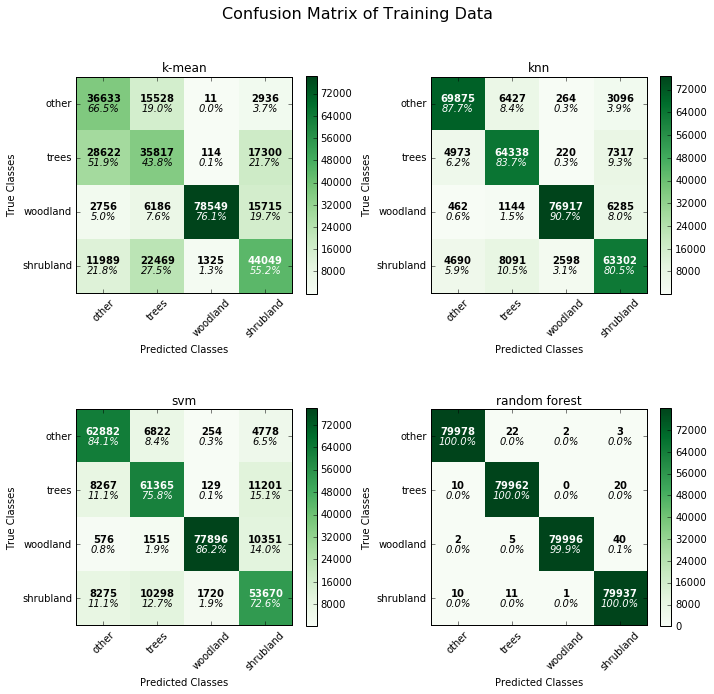

In [113]:
def plot_confusion_matrix(confmatrix, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(confmatrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.6)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    cmnorm = np.around((100*confmatrix.astype('float') / confmatrix.sum(axis=1)),1)

    

    thresh = confmatrix.max() / 2.
    for i, j in itertools.product(range(confmatrix.shape[0]), range(confmatrix.shape[1])):
        plt.text(j, i, confmatrix[i, j],
                 horizontalalignment="center", verticalalignment="bottom",
                 color="white" if confmatrix[i, j] > thresh else "black", fontsize=10, weight="bold")
        percent = str(cmnorm[i, j]) + "%"
        plt.text(j, i, percent,
                 horizontalalignment="center", verticalalignment="top",
                 color="white" if confmatrix[i, j] > thresh else "black", fontsize=10, style="italic")
        

    plt.tight_layout()
    plt.ylabel('True Classes')
    plt.xlabel('Predicted Classes')

class_names = ['other','trees','woodland','shrubland']

plt.close('all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax1 = plt.subplot(221)
plot_confusion_matrix(kmeansmatrix_trainy, classes=class_names, title='k-mean')
ax2 = plt.subplot(222)
plot_confusion_matrix(knnmatrix_trainy, classes=class_names,title='knn')
ax3 = plt.subplot(223)
plot_confusion_matrix(svmmatrix_trainy, classes=class_names,title='svm')
ax4 = plt.subplot(224)
plot_confusion_matrix(forestmatrix_trainy, classes=class_names,title='random forest')

plt.suptitle('Confusion Matrix of Training Data', fontsize=16)
plt.show()


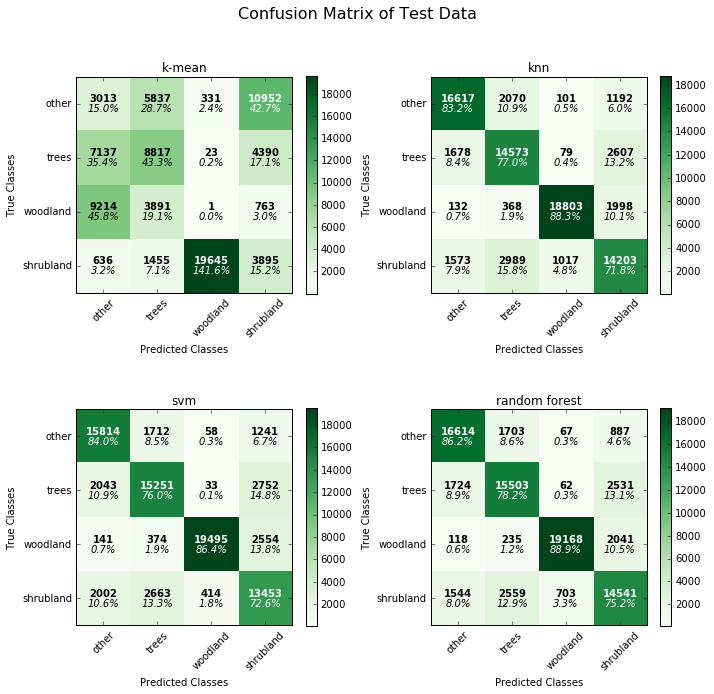

In [114]:
plt.close('all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax1 = plt.subplot(221)
plot_confusion_matrix(kmeansmatrix_testy, classes=class_names, title='k-mean')
ax2 = plt.subplot(222)
plot_confusion_matrix(knnmatrix_testy, classes=class_names,title='knn')
ax3 = plt.subplot(223)
plot_confusion_matrix(svmmatrix_testy, classes=class_names,title='svm')
ax4 = plt.subplot(224)
plot_confusion_matrix(forestmatrix_testy, classes=class_names,title='random forest')

plt.suptitle('Confusion Matrix of Test Data', fontsize=16)
plt.show()



***Week 4 – Jan 28:***
After the classification we will convert classified data into geotiff images and overly them onto the satellite images.

***Week 5 – Feb 4:***
Once the classification on the 8-Multispectrum images has been completed, I will resample the 8-Multispectral and 8-SWIR images to match the resolution of the Panchromatic Images.  I will then follow the steps laid out above and perform a classification on the 17 feature data set (8-Multispectral images, 8-SWIR images, Panchromatic Images) .